# Fitting a quadriatic form
Here lets consider the problem of optimizing elements of a coefficient matrix $A$ that generates a polynomial through a quadriatic form:
$$Q(x) \equiv y^T A y = ax^2 + 2bx + c$$
where 
$$ A \equiv \begin{bmatrix}
a & b/2 \\
b/2 & c \\
\end{bmatrix}
\quad 
y \equiv \begin{bmatrix} x & 1 \end{bmatrix}^T
$$

In [378]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

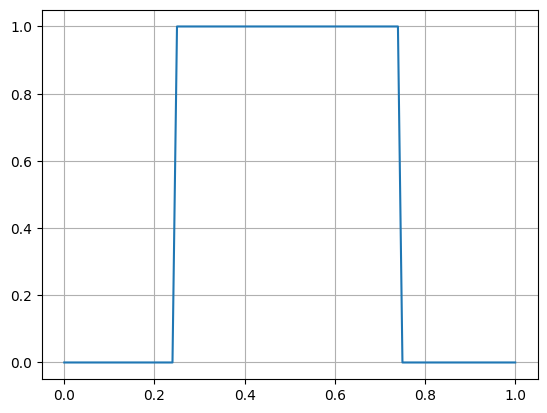

In [493]:
# parameters_ideal = torch.tensor([1,1,0.5],dtype=torch.float64)
# plt.plot(w,np.abs(computeValues(parameters_ideal,w))); plt.grid()

polynomial_target = torch.zeros(len(w))
polynomial_target = torch.zeros(len(w))
polynomial_target[int(0.25*len(w)):int(0.75*len(w))] = 1
plt.plot(w,abs(polynomial_target)); plt.grid()


In [501]:
w = torch.linspace(0,1,101,dtype=torch.complex128) # for plotting
# parameters_ideal = torch.tensor([1,1,0.5],dtype=torch.float64)
# parameters = torch.tensor([1,0.2,4],dtype=torch.float64,requires_grad=True)
# parameters = torch.tensor([0.1,0.2,4,0.1,0.2,4],dtype=torch.float64,requires_grad=True)
parameters = torch.tensor([0.01,0.02,4,0.01,0.02,4],dtype=torch.float64,requires_grad=True)

def computeValues(parameters, w):
    L1,C1,G1 = parameters[0:3]
    L2,C2,G2 = parameters[3:6]

    # Stack the components into a 3D tensor
    matrix_tensor1 = torch.stack([
        torch.stack([1 - L1 * C1 * (w**2), 1j*L1 * w], dim=-1),    # Row 1 of each matrix
        torch.stack([G1+1j*C1 * w, torch.ones_like(w)], dim=-1)  # Row 2 of each matrix
    ], dim=-2)  # Combine rows into a matrix
    matrix_tensor2 = torch.stack([
        torch.stack([1 - L2 * C2 * (w**2), 1j*L2 * w], dim=-1),    # Row 1 of each matrix
        torch.stack([G2+1j*C2 * w, torch.ones_like(w)], dim=-1)  # Row 2 of each matrix
    ], dim=-2)  # Combine rows into a matrix
    
    # matrix_tensor_final = matrix_tensor
    # matrix_tensor_final = matrix_tensor @ matrix_tensor # leading indices are batch, rmbr, so that matmul hapeens between the last two indices, which is crrect here
    # matrix_tensor_final = matrix_tensor @ matrix_tensor @ matrix_tensor
    # matrix_tensor_final = matrix_tensor @ matrix_tensor @ matrix_tensor @ matrix_tensor
    
    matrix_tensor_final = matrix_tensor1 @ matrix_tensor2
    Q = matrix_tensor_final[:,0,0]/matrix_tensor_final[:,1,0]
    return Q

def computeError(parameters):
    polynomial_w = computeValues(parameters,w)
    # polynomial_target = computeValues(parameters_ideal,w)
    # loss = torch.nn.MSELoss()(polynomial_w,polynomial_target)
    loss = torch.sum(
        torch.abs(polynomial_w-polynomial_target)**2
    )
    return loss

Iteration 0 : tensor([ -1.5365,  -0.6466,   0.3841, -25.9142,  10.3343,  20.1057],
       dtype=torch.float64, requires_grad=True);  f = 9.561457488281548
Iteration 10 : tensor([ -1.4917,  -0.6969,   0.4827, -25.9314,  10.3207,  20.1774],
       dtype=torch.float64, requires_grad=True);  f = 10.090983917029224
Iteration 20 : tensor([ -1.6044,  -0.7865,   0.4901, -25.9642,  10.3353,  20.2513],
       dtype=torch.float64, requires_grad=True);  f = 9.846763443307536
Iteration 30 : tensor([ -1.6571,  -0.7628,   0.5059, -25.6783,  10.2019,  20.4868],
       dtype=torch.float64, requires_grad=True);  f = 9.667166035683843
Iteration 40 : tensor([ -1.6426,  -0.7579,   0.4767, -25.9288,  10.3254,  20.4801],
       dtype=torch.float64, requires_grad=True);  f = 9.560507074214282
Iteration 50 : tensor([ -1.6209,  -0.7447,   0.4868, -26.0900,  10.3798,  20.5530],
       dtype=torch.float64, requires_grad=True);  f = 9.568465666169402
Iteration 60 : tensor([ -1.6359,  -0.7432,   0.4770, -26.2260,  

c:\Users\DELL\miniconda3\envs\torch\lib\site-packages\torch\_tensor.py:734: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


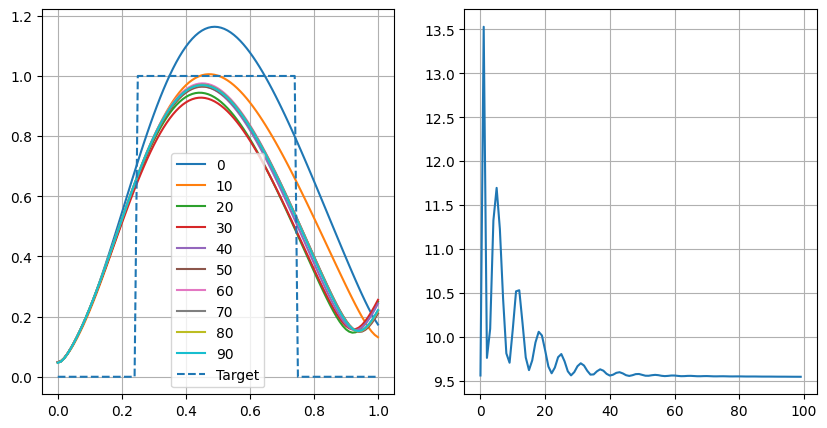

In [511]:
fig, axes = plt.subplots(1,2,figsize=(10,5)); legend = []; e = []
optimizer = torch.optim.Adam([parameters], lr=0.1) # Adaptive algorithm, better
run_iter = 100; run_interval = 10
for i in range(run_iter):
    optimizer.zero_grad()
    f = computeError(parameters)
    # f = torch.nn.MSELoss()(parameters_ideal,parameters)
    f.backward()
    optimizer.step()
    e.append(f.item())
    if(i%run_interval==0):# and i> 500):
        print(f'Iteration {i} : {parameters};  f = {f.item()}')
        axes[0].plot(w,abs(computeValues(parameters,w)).detach().numpy())
        legend.append(i)
legend.append('Target')
# axes.plot(w,abs(computeValues(parameters_ideal,w)).detach().numpy(),linestyle='dashed')
# print(f'Ideal parameters: {parameters_ideal}')
axes[0].plot(w,abs(polynomial_target).detach().numpy(),linestyle='dashed')
axes[0].legend(legend)
axes[0].grid('on')
axes[1].plot(e); axes[1].grid('on')